In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import rand_score
from sklearn.metrics.cluster import silhouette_score

from warnings import filterwarnings
filterwarnings('ignore')

%matplotlib inline

rand_state = 42

# 1. Load the dataset and explore it

In [4]:
data = pd.read_csv('./exam_superv.csv')
data.head()

,0,1,y,2
0,1.589942,2.977770,0,1.953805
1,2.908437,1.837522,1,1.510049
2,3.284091,1.818476,1,3.307287
3,3.148717,2.071991,1,3.452021
4,2.116881,2.133874,0,2.157870


In [30]:
print(f'data dimensions are: {data.shape}')

data dimensions are: (1200, 4)


In [5]:
label = 'y'
data[label] = data[label].astype(str)
data.describe()

,0,1,2
count,1200.000000,1200.000000,1200.000000
mean,2.391668,1.996186,2.494236
std,0.804770,0.507227,0.589235
min,0.343023,0.509424,1.500260
25%,1.806657,1.809635,1.974389
50%,2.744439,1.983524,2.469778
75%,3.092275,2.201484,2.995198
max,3.529782,3.647299,3.498523


In [6]:
data[label].describe()

count     1200
unique       2
top          1
freq       609
Name: y, dtype: object

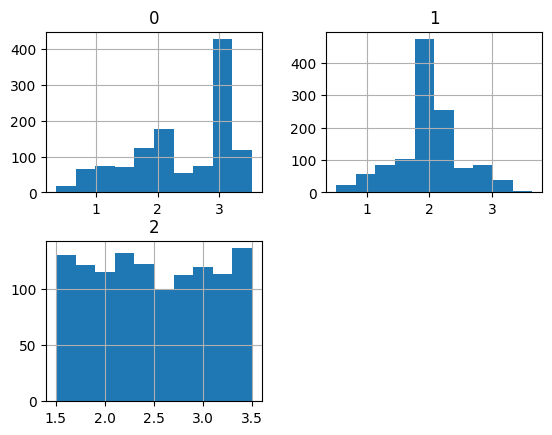

In [9]:
data.hist();

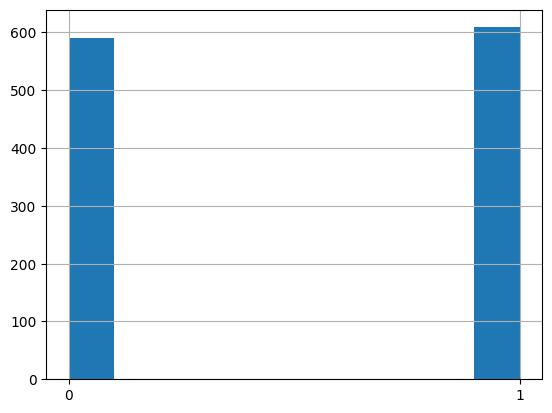

In [11]:
data[label].hist();

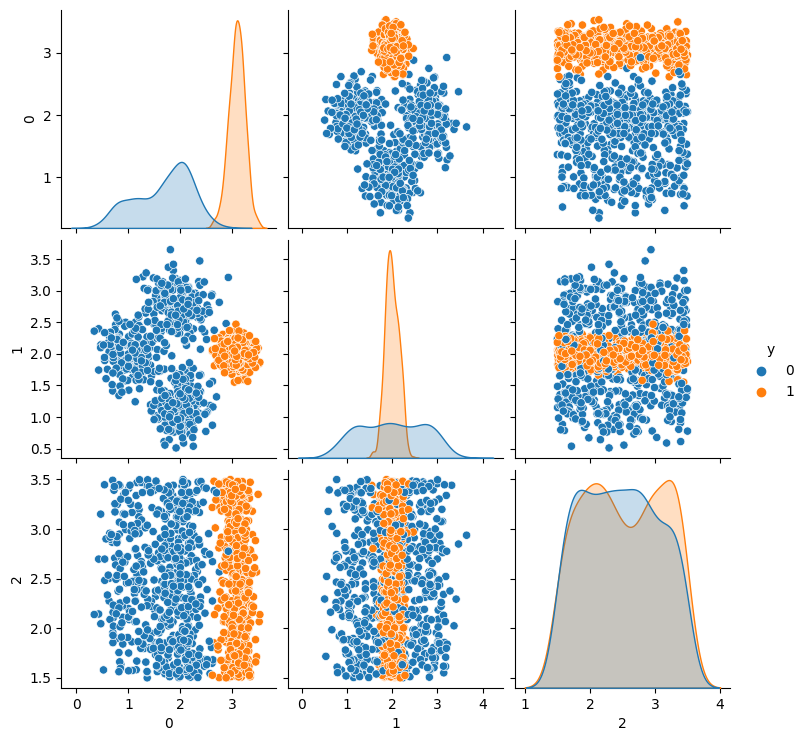

In [13]:
sns.pairplot(data, hue='y');

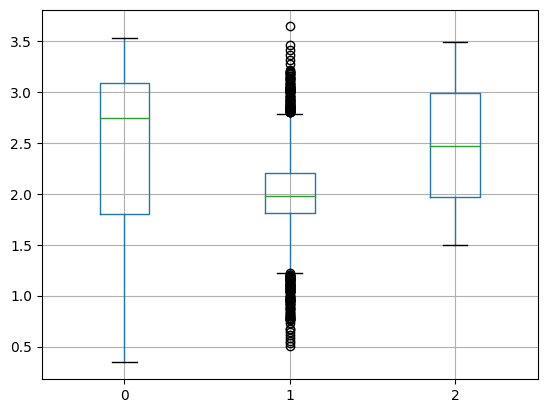

In [17]:
data.boxplot();

# 2. find the best clustering scheme

#### Since the column 2 gives little insight about the data, we can drop it.
No other trasformations are needed

In [15]:
filtered_data = data.drop('2', axis=1)

In [18]:
X = filtered_data.drop(label, axis=1)
y = filtered_data[label]

#### We can now try a clustering scheme

In [61]:
parameters_k_means = list(ParameterGrid([{'n_clusters': range(2,7)}]))

silhouette_values = []
inerita_values = []

for i in range(len(parameters_k_means)):
    parameter = parameters_k_means[i]
    model = KMeans(**(parameter), random_state=rand_state)
    y_predicted = model.fit_predict(X)
    inerita_values.append(model.inertia_)
    silhouette_values.append(silhouette_score(X, y_predicted))

Plot the silhouette and inertia values in order to find the best parameters.

In [25]:
def two_plots(x, y1, y2, xlabel, y1label, y2label):

	fig, ax1 = plt.subplots()
	
	color = 'tab:red'
	ax1.set_xlabel(xlabel)
	ax1.set_ylabel(y1label, color=color)
	ax1.plot(x, y1, color=color)
	ax1.tick_params(axis='y', labelcolor=color)
	
	ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis
	color = 'tab:blue'
	ax2.set_ylabel(y2label, color=color) # we already handled the x-label with ax1
	ax2.plot(x, y2, color=color)
	ax2.tick_params(axis='y', labelcolor=color)
	ax2.set_ylim(0,1) # the axis for silhouette is [0,1]
	fig.tight_layout() # otherwise the right y-label is slightly clipped
	
	plt.show()

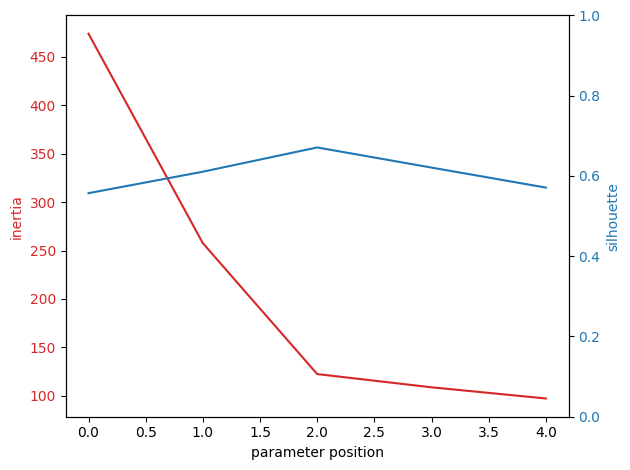

In [62]:
two_plots(range(len(parameters_k_means)), inerita_values, silhouette_values, 'parameter position', 'inertia', 'silhouette')

The elbow method suggest to use parameters 1 or 2 for the inertia but the silhouette has max value with the parameter in position 2

In [34]:
print(f'the best parameters are: {parameters_k_means[2]}')

the best parameters are: {'n_clusters': 4}


In [63]:
k_means_model = KMeans(**(parameters_k_means[2]), random_state=rand_state)
y_k_means = k_means_model.fit_predict(X)

### Since we have a gold standard we can use it to test the performance of our clustering scheme

In [64]:
print(f'The rand score of the k_means_model is: {rand_score(y, y_k_means)}')

The rand score of the k_means_model is: 0.83267306088407


A .83 value for the rand score is not bad but let's put it agaist the score with only 2 clusters and see how it compares

In [65]:
k_means_gold_standard = KMeans(n_clusters=2, random_state=rand_state)
y_k_means_gold_standard = k_means_gold_standard.fit_predict(X)
print(f'The rand score of the k_means_model is: {rand_score(y, y_k_means_gold_standard)}')

The rand score of the k_means_model is: 0.9185446205170976


Even though the inertia and the silhouette values point to a 4 clusters clustering scheme, the gold standard tells us that a 2 clusters clustering scheme is more accurate.

## Let's repeat the process with DBSCAN

#### We're gonna start with a paramer selection process

In [41]:
min_sample = 2 * X.shape[1]
print(f'a good min_sample starting value is: {min_sample}')

a good min_sample starting value is: 4


In [42]:
def k_distance(X, k):

	k_distances = []
	for i in range(0, X.shape[0]):
		k_point_distances = []
		for j in range(0, X.shape[0]):
			if i!=j:
				dist = np.sqrt(sum((X[i,:]-X[j,:])**2))
				k_point_distances.append(dist)
		k_point_distances.sort()
		k_distances.append(k_point_distances[k-1])
		
	k_distances.sort(reverse=True)
	return k_distances

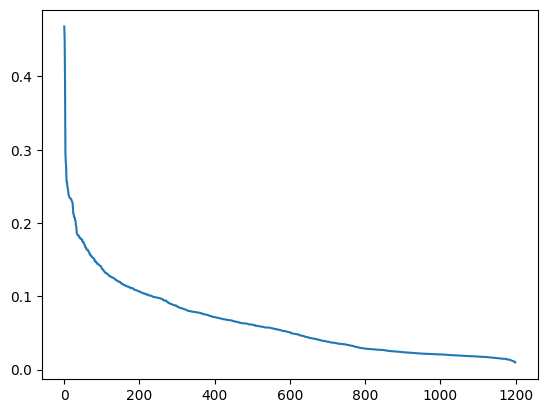

In [45]:
k_distances = k_distance(np.array(X), min_sample)

plt.plot(range(len(k_distances)), k_distances);

Using the elbow method we can select .2 as a good starting value for eps

In [49]:
eps = 0.2

parameters_dbscan = list(ParameterGrid([{'min_samples': range(int(min_sample / 2), int(min_sample * 2)), 'eps': np.arange(eps / 2, eps * 2, 0.1)}]))

results = []

for i in range(len(parameters_dbscan)):
    parameter = parameters_dbscan[i]
    model = DBSCAN(**(parameter))
    y_predicted = model.fit_predict(X)

    n_clusters = len(y_predicted[y_predicted != -1])
    if n_clusters > 1:
        row = parameter.copy()
        silhouette = silhouette_score(X, y_predicted)
        unclustered = len(y_predicted[y_predicted == -1]) / len(y_predicted)
        row['silhouette'] = silhouette
        row['unclustered%'] = unclustered
        row['i'] = i
        results.append(row)

results_df = pd.DataFrame(results)

We can now sort our values by silhouette and unclustered percentage in order to select the best set of parameters.

In [50]:
results_df.sort_values(by=['silhouette', 'unclustered%'], ascending=False, inplace=True)
results_df.head()

,eps,min_samples,silhouette,unclustered%,i
11,0.2,7,0.509362,0.011667,11
3,0.1,5,0.458365,0.121667,3
5,0.1,7,0.433129,0.176667,5
4,0.1,6,0.376823,0.141667,4
1,0.1,3,0.335525,0.053333,1


In [57]:
best_parameters_db_scan = parameters_dbscan[int(results_df.iloc[0]["i"])]
print(f'the best parameters for dbscan are: {best_parameters_db_scan}')

the best parameters for dbscan are: {'eps': 0.2, 'min_samples': 7}


In [58]:
dbscan = DBSCAN(**(best_parameters_db_scan))
y_dbscan = dbscan.fit_predict(X)
print(f'The rand score of the k_means_model is: {rand_score(y, y_dbscan)}')

The rand score of the k_means_model is: 0.9821990547678621


# 3: show the difference between the original y and the label generated
The best clustering method is dbscan and so we're gonna use that one

In [69]:
model = DBSCAN(**(best_parameters_db_scan))
y_predicted = dbscan.fit_predict(X)

Remap y_predicted in order to have the same values as the original y

In [66]:
def transform(y_true, y_pred):
	y_mapped = y_pred.copy()
	for lab in np.unique(y_pred):
		if y_true.str.contains(lab).any():
			true_l, count = np.unique(y_true[y_pred==lab], return_counts=True)
			y_mapped[y_pred==lab] = true_l[np.argmax(count)]
		else:
			y_mapped[y_pred==lab] = lab
	return y_mapped

In [70]:
y_remapped = y_predicted.astype(str)
y_remapped = transform(y, y_remapped)

In [71]:
accuracy = round(accuracy_score(y, y_remapped), 2) * 100
print(f'the accuracy of the clustering scheme against the gold standard is: {accuracy}%')

the accuracy of the clustering scheme against the gold standard is: 98.0%


In [75]:
print(f'the confusion matrix of the clustering scheme against the gold standard is:\n {confusion_matrix(y[y_remapped != "-1"], y_remapped[y_remapped != "-1"])}')

the confusion matrix of the clustering scheme against the gold standard is:
 [[573   4]
 [  0 609]]


## A visual representation of the clustering scheme

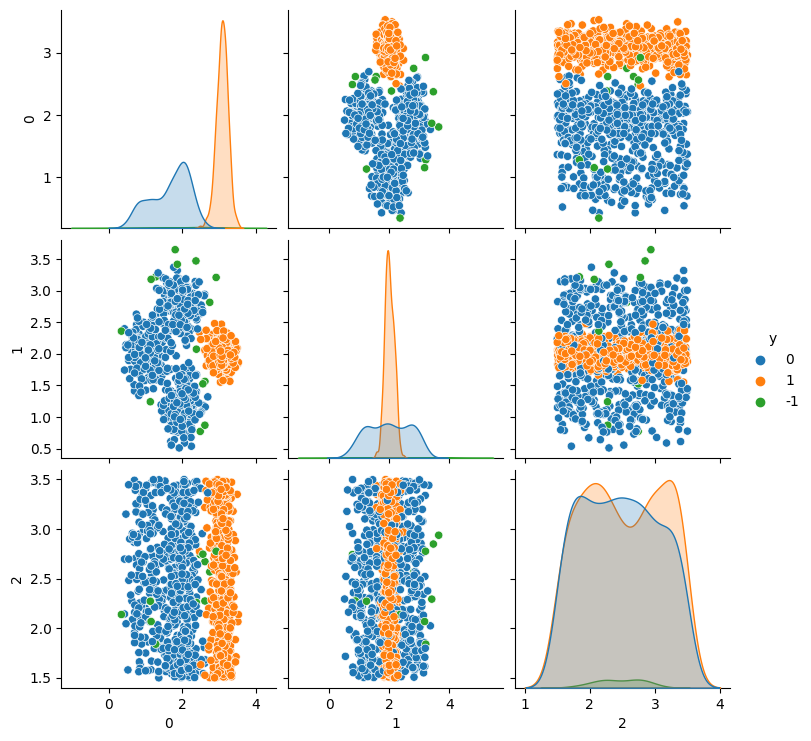

In [76]:
plot_data = data.copy()
plot_data['y'] = y_remapped
sns.pairplot(plot_data, hue='y');

# 4: Apply the same trasmation and the same clustering scheme to a new dataset

In [83]:
new_dataset = pd.read_csv('./exam_unsuperv.csv')
new_dataset.head()

,0,1,2
0,3.185684,2.208597,3.045639
1,2.179220,1.410352,2.396246
2,2.242676,2.624663,2.833286
3,1.980176,0.836695,2.188114
4,3.210992,2.251962,3.309826


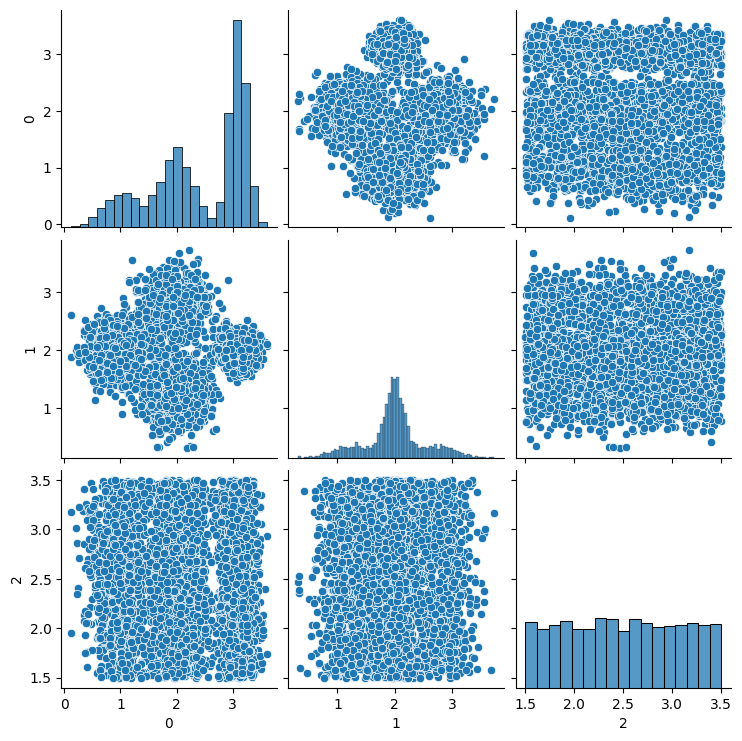

In [84]:
sns.pairplot(new_dataset);

In [80]:
X = new_dataset.drop(['2'], axis=1)

In [82]:
y_predicted_new_dataset = model.fit_predict(X)

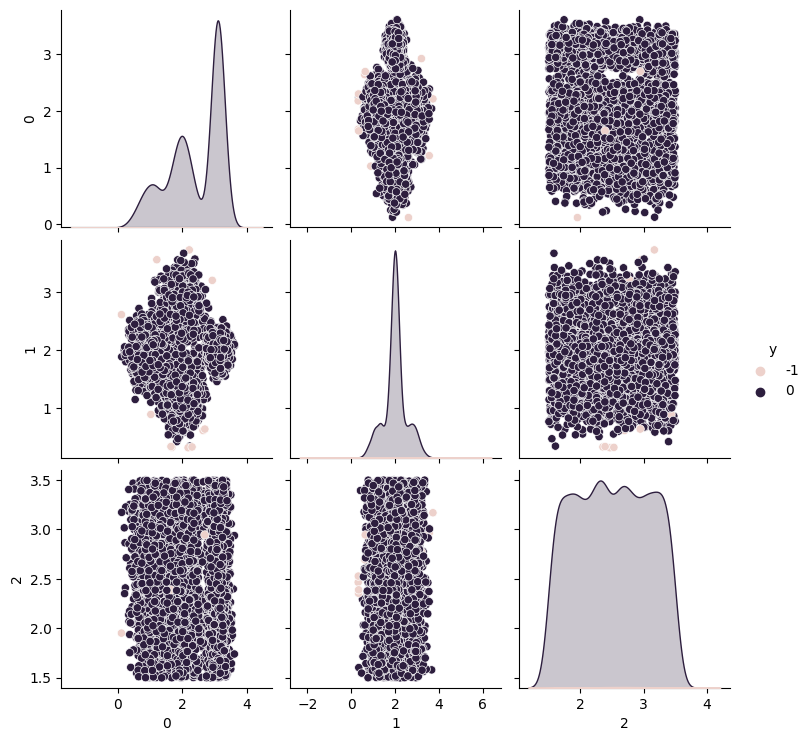

In [86]:
plot_new_dataset = new_dataset.copy()
plot_new_dataset['y'] = y_predicted_new_dataset
sns.pairplot(plot_new_dataset, hue='y');

The clustering scheme obtained with the previus data gives a bad result with this new dataset. A new clustering scheme should be developed